Following useful websites:

[Latitude&LongitudeFinder](https://www.latlong.net/)

[Foursquare Explore API](https://developer.foursquare.com/docs/api-reference/venues/explore/)

[Foursquare Search Venue API](https://developer.foursquare.com/docs/api-reference/venues/search/)

Basic Thinking: 

Use Explore API to search a grid of London Lat and Longitudes, using the initially returned data on number of results in area to then use the offset attribute of the API to try and scrape all venues at that lat and longitude. 

Note need to set limit to 50 to get max returned venues and note can't get more than 50 but offset attribute shifts through results to get the 50 next results i.e. you set offset from 0 to 50 and you'll have gotten 100 total results from 2 calls. By tweaking radius and lat / longitude granularity and looking at the 'total results returned' data from the json returned, we should hopefully be able to get all the venues.   

Also need to check the resulting venues actually are an event space e.g. spot check results are useful. 

Afterwards for Public space - may be useful to cross check the venues found with rich data from other API calls e.g. Venue Details API, and finding venues with little data i.e. new venues would be the prioritised candidates.  

Step 1 - Make script to pull out results from return into a nice table, and note the useful info for prioritisation i.e. 'verified' as well as customers there and stuff. 

Step 2 - create plan for grid search of london and 2 calls (offset = 0 and offset = 50) and varying radius and granularity based on number of results returned. Be careful to estimate total calls because limited to 950 a day (half that if you do 2 calls due to offset) unless you verify in which case we can make many more calls. 

In [ ]:
import json
import requests
from IPython.display import JSON

In [ ]:
url = 'https://api.foursquare.com/v2/venues/search'

params = dict(
client_id = 'AAXRKU2CAOL43SHYGZJGEHKOSW0ACUNX2PD3JLB22U0WFFNA',
client_secret = 'FHVL3UYDBWRNVHVQ11FOR0Z4LFWSDIRL1HW3OCZNERUEAG1F',
v = '20180323',
near = 'London, UK',
category = '4bf58dd8d48988d171941735',
#ll = '40.7243,-74.0018',
#query = 'coffee',
limit = 50
)
resp = requests.get(url=url, params=params)
data = json.loads(resp.text)

In [ ]:
JSON(data)

In [ ]:
url = 'https://api.foursquare.com/v2/venues/explore'

params = dict(
client_id = 'AAXRKU2CAOL43SHYGZJGEHKOSW0ACUNX2PD3JLB22U0WFFNA',
client_secret = 'FHVL3UYDBWRNVHVQ11FOR0Z4LFWSDIRL1HW3OCZNERUEAG1F',
v = '20180323',
#near = 'London, UK',
category = '4bf58dd8d48988d171941735',
ll = '51.502380,-0.071414',
offset = 1,
sortByDistance = 1,
radius = 8000,
#query = 'coffee',
limit = 50
)
resp = requests.get(url=url, params=params)
data_explore = json.loads(resp.text)
JSON(data_explore)

In [ ]:
200 * 2 *100

In [1]:
import json
import ast
import random
import requests
from IPython.display import JSON
from ratelimiter import RateLimiter
from statistics import median, mean
import plotly.express as px
from geopy import distance
from scipy.optimize import newton
import numpy as np
import pandas as pd
import time
from joblib import Parallel, delayed
from json.decoder import JSONDecodeError

### Key Variables

- **key** is the foursquare api key credential
- **url** is main foursquare 'places' api url to perform a venue search. 
- **minimum and maximum latitude and longitudes** define a square projection on the earth's surface that defines the search area. 

In [2]:
key = 'fsq3MYXlFApTX2z3Q5dOBckbXHSnG9a7pbwgZkIP8vz4YNw='
url = "https://api.foursquare.com/v3/places/search"
headers = {
        "Accept": "application/json",
        "Authorization": key
    }

min_lat = 51.438499 
max_lat = 51.546890
min_long = -0.240612
max_long = 0.026043

In [3]:
@RateLimiter(max_calls=49, period=1)
def api_call(long_lat, radius, key):
    """Perform a foursquare places api search and return results.  
    
    The places api search requires a location (latitude and longitude) 
    and radius to determine the search area. We also use  2 category 
    codes for indoor and outdoor event spaces, resticting our 
    results to showing only venues with event spaces. 
    
    Note that the function use the @Ratelimiter decorator to restrict the 
    calling of this function to 49 calls per second to comply with the 
    foursquare api rate limits.  
    
    Returns - response from foursquare api (top 50 event spaces closest 
    to the latitude / longitude values provided that offer an event space)"""
    
    # Defines paramaters to add to the main 'places' api url
    params = dict(ll = long_lat,
                  radius = radius, 
                  #categories='11131,11039',
                  categories='10039,10040,10041,10045,10049,11039,13003',
                  sort='DISTANCE',
                  limit='50'
                 )
    # defines headers to include in the 'places' api search
    headers = {
        "Accept": "application/json",
        "Authorization": key
    }

    return requests.request("GET", url, headers=headers, params=params)

In [4]:
response = api_call('51.513882,-0.119478', '1000', key)
results = json.loads(response.text)
JSON(results)

<IPython.core.display.JSON object>

In [ ]:
response = api_call('51.51199919197119,-0.05217038902188603', '3000', key)
results = json.loads(response.text)
JSON(results)

In [ ]:
pagination = response.headers['Link']
next_results_url = pagination[pagination.find('<') + 1
                                          :pagination.find('>')]
response = requests.get(next_results_url, headers = headers)
results = json.loads(response.text)
JSON(results)

In [ ]:
distance.distance((51.40003900142309, -0.07528424263000488),(51.51199919197119,-0.05217038902188603)).m

In [ ]:
#num_results = len(results['results'])

options for radius calculation: use last radius, use moving average radius, 

In [ ]:
def find_radius(long_lat, search_radius, key):
    num_api_calls = 0
    radius_found = True
    while(radius_found):
        response = api_call(long_lat, search_radius, key)
        num_api_calls += 1
        results = json.loads(response.text)
        num_results = len(results['results'])
        
        if num_results == 50:
            radius = results['results'][-1]['distance']
            radius_found = False
        else:
            search_radius = search_radius * 2
        
    return int(radius), num_api_calls

In [ ]:
total_requests = 127
cost_per_request = 0.5
total_price_in_dollars = total_requests * cost_per_request / 100
print(f"Total price for {total_requests} requests is ${total_price_in_dollars}")

In [ ]:
trials = 1000
radii = []
total_api_calls = 0

for trial in range(trials):
    search_radius = 10000
    latitude = random.uniform(min_lat, max_lat)
    longitude = random.uniform(min_long, max_long)
    
    lat_long = str(latitude) + ',' + str(longitude)
    radius, num_api_calls = find_radius(lat_long, search_radius, key)
    radii.append(radius)
    total_api_calls += num_api_calls

max_radius = max(radii)
min_radius = min(radii)

print(f"Max radius = {max_radius}")
print(f"Min radius = {min_radius}")
print(f"Total API calls = {total_api_calls}")

In [ ]:
total_api_calls

In [ ]:
min(radii)

In [ ]:
fig = px.histogram(radii)
fig.show()

In [ ]:

long_lat1 = (max_lat, min_long)
long_lat2 = (max_lat, max_long)
distance1 = distance.distance(long_lat1, long_lat2).km * 1000

In [ ]:
long_lat1 = (min_lat, min_long)
long_lat2 = (max_lat, min_long)
distance2 = distance.distance(long_lat1, long_lat2).km * 1000

In [ ]:
distance2

In [ ]:
total_area = distance1 * distance2

In [ ]:
search_area = 3.14 * 3271 * 3271

In [ ]:
approx_searches = total_area / search_area

In [ ]:
print(f"total area = {total_area}")
print(f"search area = {search_area}")
print(f"searches_required = {approx_searches}")

In [ ]:
51.505177-51.535

In [ ]:
distance.distance((51.505177,-0.092172), (51.505177,-0.1402)).m

In [ ]:
-0.092172--0.1402

In [ ]:
pagination = response.headers['Link']

In [ ]:
next_results_url = pagination[pagination.find('<') + 1:pagination.find('>')]

In [ ]:
response2 = requests.get(next_results_url, headers = headers)

In [ ]:
response2.headers

In [ ]:
data_explore2 = json.loads(response2.text)
JSON(data_explore2)

In [ ]:
def xsq(x):
    return x - 2

In [ ]:
def objective_function(x):
    return 3 * x ** 4 - 2 * x + 1

### Calculate Latitude Longitude Grid Tick Sizes

In [5]:
def lat_min_tick_size(lat_increment, radius):
    return distance.distance((test_lat, test_long), (lat_increment, test_long)).m - radius

def long_min_tick_size(long_increment, radius):
    return distance.distance((test_lat, test_long), (test_lat, long_increment)).m - radius

test_lat = 51.505177
test_long = -0.092172

def find_tick_sizes(radius):
    

    lat_increment = newton(lat_min_tick_size, test_lat, args = (radius,))
    long_increment = newton(long_min_tick_size, test_long, args = (radius,))
    
    # divide by 3 to get smaller resolution, least likely to miss venues 
    lat_tick_size = abs(test_lat - lat_increment) / 2
    long_tick_size = abs(test_long - long_increment) / 2

    return lat_tick_size, long_tick_size

### Create Latitude Longitude Grid

Probably need to formalise the tick size thing based on the typical radius search area...if I change categories for example..

In [6]:
def create_lat_long_grid(lat_tick_size, long_tick_size):

    lat_ticks = (max_lat - min_lat) / lat_tick_size
    long_ticks = (max_long - min_long) / long_tick_size
    
    lat_range = np.arange(min_lat, max_lat + lat_tick_size, lat_tick_size)
    long_range = np.arange(min_long, max_long + long_tick_size, long_tick_size)
    return [str(lat) + ',' + str(long) for long in long_range for lat in lat_range]

### Venue Search

In [7]:
def extract_venues(venue_list):
    venues = []
    for venue in venues_list:
        fsq_id = venue['fsq_id']
        latitude = venue['geocodes']['main']['latitude']
        longitude = venue['geocodes']['main']['longitude']
        venue_name = venue['name']
        try: 
            venue_address = venue['location']['address']
        except KeyError:
            venue_address = ''
        try:
            venue_postcode = venue['location']['postcode']
        except KeyError:
            venue_postcode = ''
            
        venues.append([fsq_id, venue_name, latitude, longitude, 
                       venue_address, venue_postcode])
    return venues

In [ ]:
#
#data = Parallel(n_jobs=-1, verbose = 0)(delayed(my_function)(x, y) for x, y in zip(list_x, list_y))


In [9]:
#radius = 400
#lat_tick_size, long_tick_size = find_tick_sizes(radius)
#lat_long_grid = create_lat_long_grid(lat_tick_size, long_tick_size)
#print(f"lat_long_grid size = {len(lat_long_grid)}")

In [11]:
#lat_long_searched = '51.505177,-0.092172'#

In [15]:
#len(lat_long_grid)

12880

In [25]:
#%%timeit
#bools = Parallel(n_jobs=-1, verbose = 0)(delayed(check_in_radius)(radius, lat_long_searched, lat_long) for lat_long in lat_long_grid)
#[lat_long for lat_long, T_F in zip(lat_long_grid, bools) if T_F]

361 ms ± 3.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
#%%timeit
#[lat_long for lat_long in lat_long_grid if check_in_radius(radius, lat_long_searched, lat_long)]

In [55]:
def update_grid(lat_long_searched, radius, lat_long_grid):
    # Using multi-processing to speed up the removal of lat_long points
    #from grid, is equivalent of following list comprehension: 
    # [lat_long for lat_long in lat_long_grid 
    # if check_in_radius(radius, lat_long_searched, lat_long)]
    # Below we get a boolean list of True / False if lat_long is within search radius 
    bools = Parallel(n_jobs=-1, verbose = 0)(delayed(check_in_radius)(radius, lat_long_searched, lat_long) for lat_long in lat_long_grid)
    # Filter out the lat_longs which were within the radius i.e. value = False in bools
    return [lat_long for lat_long, T_F in zip(lat_long_grid, bools) if T_F]

def check_in_radius(radius, lat_long_searched, lat_long):
    return distance.distance(ast.literal_eval(lat_long_searched), ast.literal_eval(lat_long)).m >= radius + 0.1

# Note the +0.1 is due to the changing latitude / longitude values over ranges.. basically adding an error of 100cm 

In [ ]:
#len(lat_long_grid)
#new_grid = update_grid(lat_long_grid[50], radius, lat_long_grid)

In [ ]:
#distance.distance(lat_long_grid[5], (51.51199919197119,-0.21705679862773575)).m

### To Do

- Better search for in radius 
- add double set of results? 
- smart search via increasing grid density for bad searches -> beware of many failed searches if using large initial radius 

In [ ]:
initial_search_radius = 1000
min_grid_radius = 30

lat_tick_size, long_tick_size = find_tick_sizes(min_grid_radius)
lat_long_grid = create_lat_long_grid(lat_tick_size, long_tick_size)
print(f"lat_long_grid size = {len(lat_long_grid)}")

time_last_update = time.time()
data = []

total_calls = 0
number_needed_retries = 0 
number_lat_long_in_last_20 = 0
radius_too_big = False 
while len(lat_long_grid) > 0:
    #print('restarted')
    # maximum index available in lat_long_grid
    max_index = len(lat_long_grid) - 1
    # Pick random index for lat_long_grid
    random_index = random.randint(0, max_index)
    # Pick lat and long values from random position in lat_long_grid
    lat_long = lat_long_grid[random_index]
    
    search_radius_not_found = True
    search_radius = initial_search_radius
    
    while search_radius_not_found:
        #print('calling api')
        total_calls += 1
        response = api_call(lat_long, search_radius, key)
        # If response status code isnt 200, there was an API error. Print 
        # the API error, wait 5 seconds and try API call again. Loop until 
        # status 200 code returned by API. 
        while response.status_code != 200:
            print(f"API Error code {response.status_code}, sleeping 5 seconds")
            time.sleep(5)
            response = api_call(lat_long, search_radius, key)
        
        results = json.loads(response.text)
        venues_list = results['results']
        
        if len(venues_list) > 49:
            search_radius = int(search_radius / 2)
            radius_too_big = True
            print('radius too large') 
        else: 
            search_radius_not_found = False
    
    if search_radius < min_grid_radius:        
        print(f"Search Radius smaller than min_grid_radius:\nlat_long = {lat_long}\nsearch radius = {search_radius}")
        print(f"\nUpdating min_grid_radius to {search_radius} and resetting grid...\n")
        # update radius to max_distance minus 1 (ensures radius will now be smaller than max distance next time)
        min_grid_radius = search_radius
        lat_tick_size, long_tick_size = find_tick_sizes(min_grid_radius)          
        lat_long_grid = create_lat_long_grid(lat_tick_size, long_tick_size)
        print(f"lat_long_grid size = {len(lat_long_grid)}")
        # reset data gathering
        data = []
 
        radius_too_big = False
        number_lat_long_in_last_20 = 0 
        number_needed_retries = 0
        time_last_update = time.time()
        continue
    
    number_lat_long_in_last_20 += 1
    number_needed_retries += radius_too_big
    radius_too_big = False
    
    #print('data about to be scraped')
    data.extend(extract_venues(venues_list))
           
    lat_long_grid = update_grid(lat_long, search_radius, lat_long_grid)
    #print('done one grid mark --> ', len(lat_long_grid))
    if time.time() - time_last_update > 20:
        print(f"lat_long_grid points remaining -> {len(lat_long_grid)}")
        
        fraction_of_retries = number_needed_retries / number_lat_long_in_last_20
        if fraction_of_retries > 0.6 and number_lat_long_in_last_20 > 6:
            print(f"{number_needed_retries} out of {number_lat_long_in_last_20} " 
                  + f"searches had too large radius --> {fraction_of_retries:.1%}")
            initial_search_radius = int(initial_search_radius * 0.8)
            print(f"Reducing Initial Search Radius to {initial_search_radius}")
        print(number_lat_long_in_last_20)
        time_last_update = time.time()
        number_lat_long_in_last_20 = 0 
        number_needed_retries = 0 
    
print(f"\nTotal Calls -> {total_calls}")

In [21]:
%%timeit
[i for i in lat_long_grid]

33.2 ms ± 363 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [51]:
results = json.loads(response.text)
results

{'message': "radius: '1000.0' is not a valid Integer"}

### To Do latest: 

- api error handling fixes - use response.status_code and maybe some of those things on that website, add to cheatsheet anyway 
- Add new variable radius model - min radius for gridsize and separate general radius and specific radius per search! - check if probelms with data using large surface area i.e. nonsense results shown? 

In [30]:
min size = 127

500

Error - 100 or more venues in search, cannot extract all venues in search area.
lat_long = 51.49814499999999,-0.16857000000000005
radius = 3271
Error - 100 or more venues in search, cannot extract all venues in search area.
lat_long = 51.48323349999999,-0.1205420000000001
radius = 3271
Error - 100 or more venues in search, cannot extract all venues in search area.
lat_long = 51.51305649999998,-0.048500000000000154
radius = 3271
Error - 100 or more venues in search, cannot extract all venues in search area.
lat_long = 51.52796799999998,-0.048500000000000154
radius = 3271

In [61]:
df = pd.DataFrame(data, columns = ['fsq_id', 'venue_name', 'latitude', 'longitude', 
                       'address', 'postcode'])
#df.head()
df = df.drop_duplicates(subset=['fsq_id'])
df.shape[0]

373

In [62]:
df[(min_lat <= df.latitude) & (df.latitude <= max_lat) 
   & (df.longitude > min_long) & (df.longitude < max_long)].shape[0]

333

In [ ]:
df2 = pd.read_csv('foursquare_event_spaces.csv')
df2.head()

In [ ]:
df2[(min_lat <= df2.latitude) & (df2.latitude <= max_lat) 
   & (df2.longitude > min_long) & (df2.longitude < max_long)].shape[0]

In [ ]:
df.to_csv('foursquare_bars.csv', index = False)

In [ ]:
print(f"Error - 100 or more venues in search, cannot"
                     + f"blurg")

### Maps

In [117]:
# Find lat and long ticksize required for a grid with separation of 3000m
lat_tick_size, long_tick_size = find_tick_sizes(1000)
# Create lat long grid with seperateion 3000m between tick marks that 
# bounds the square projection of the min_lat, max_lat, min_long, max_long 
lat_long_grid = create_lat_long_grid(lat_tick_size, long_tick_size)

lat_long_grid[0:5]

['51.438499,-0.240612',
 '51.442993058121644,-0.240612',
 '51.44748711624329,-0.240612',
 '51.45198117436493,-0.240612',
 '51.456475232486575,-0.240612']

In [132]:
# Convert lat_long_grid list into a list of lists where each list has 
# format [latitude, longitude, lat_long] e.g. [51.3, 0.01, '51.3,0.01']
lat_long_split = [lat_long.split(',') + [lat_long] for lat_long in lat_long_grid] 
# Convert into a dataframe
df_lat_long = pd.DataFrame(lat_long_split, columns = ['latitude', 
                                                      'longitude', 'lat_long'])
# Convert the latitude and longitude columns to float
df_lat_long[['latitude', 'longitude']] = (df_lat_long[['latitude', 'longitude']]
                                          .applymap(float))
# Select a lat_long value from the lat_long grid (use 55 then 30)
lat_long_point = df_lat_long.loc[620,'lat_long']
# Define radius from this point that we want to identify 
radius_from_point = 1000
# Create new column that shows True or False if another point is 
# within radius_from_point of the lat_long_point.  
df_lat_long['in_radius'] = [check_in_radius(radius_from_point, 
                                            lat_long_point, lat_long) 
                            for lat_long in df_lat_long.lat_long]

df_lat_long.head()

,latitude,longitude,lat_long,in_radius
0,51.438499,-0.240612,"51.438499,-0.240612",True
1,51.442993,-0.240612,"51.442993058121644,-0.240612",True
2,51.447487,-0.240612,"51.44748711624329,-0.240612",True
3,51.451981,-0.240612,"51.45198117436493,-0.240612",True
4,51.456475,-0.240612,"51.456475232486575,-0.240612",True


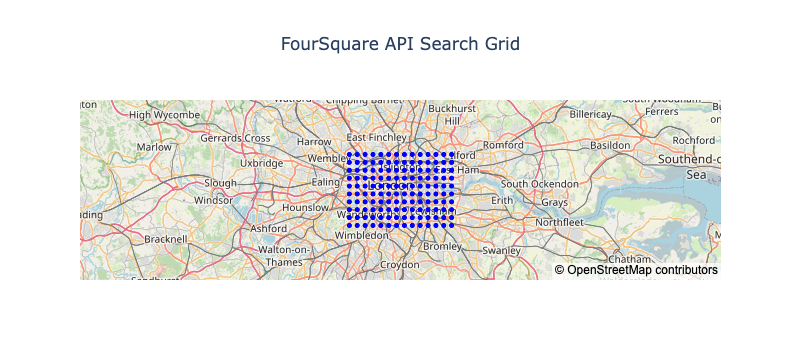

In [82]:
# Plot on map, with red for not unique and blue for unique
fig = px.scatter_mapbox(df_lat_long, lat="latitude", lon="longitude", hover_name="lat_long",  
                   size_max=15, zoom=8, title='FourSquare API Search Grid', opacity = 1,  
                        color_discrete_sequence=['blue'])
fig.update_layout(mapbox_style="open-street-map", title_text='FourSquare API Search Grid', title_x=0.5)
fig.show()

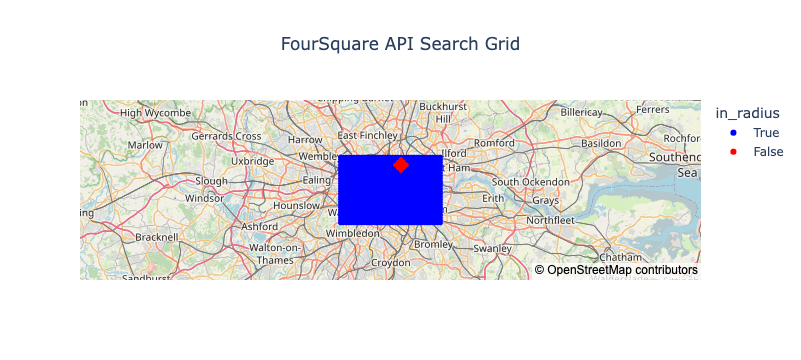

In [133]:
# Plot on map, with red for not unique and blue for unique
fig = px.scatter_mapbox(df_lat_long, lat="latitude", lon="longitude", hover_name="lat_long",  
                   size_max=15, zoom=8, title='FourSquare API Search Grid', opacity = 1, color = 'in_radius', 
                        color_discrete_sequence=['blue', 'red'])
fig.update_layout(mapbox_style="open-street-map", title_text='FourSquare API Search Grid', title_x=0.5)
fig.show()

131, 131 - 20, 3003.49
1, 1 + 20, 3003.49
8, 8+20, 2997.29

In [112]:
distance.distance(lat_long_point,df_lat_long.loc[8 + 20,'lat_long']).m

2997.295137048203

In [ ]:
80 - 19, 80 + 20 

In [111]:
df_lat_long.loc[8 + 20,'lat_long']

'51.546356228713954,-0.1974046603955278'

In [58]:
# Update grid then rerun the above code (not worth coding this permanatly,
# mainly for debugging and explaining)

lat_long_grid = update_grid(lat_long_point, radius_from_point, lat_long_grid)

In [ ]:
response

In [ ]:
response.headers['Link']

In [ ]:
lat_long_grid[0:2]

In [ ]:
lat_long = lat_long_grid[1]
response = api_call(lat_long, 3271, key)


In [ ]:
results = json.loads(response.text)
venues_list = results['results']
extract_venues(venues_list)

In [ ]:
JSON(venues_list)

In [ ]:
JSON(venues_list)

In [ ]:
venues_list[0]['location']['address']

In [ ]:
data = []
while len(lat_long_grid) > 0:
    
    response = api_call(lat_long, radius, key)
    results = json.loads(response.text)
    venues_list = results['results']
    data.extend(extract_venues(venues_list))
    # if 50 results then check second page of results
    if len(venues_list) == 50:
        try:
            pagination = response.headers['Link']
            next_results_url = pagination[pagination.find('<') + 1
                                          :pagination.find('>')]
            response = requests.get(next_results_url, headers = headers)
            results = json.loads(response.text)
            venues_list = results['results']
            data.extend(extract_venues(venues_list))
            if len(venues_list) == 50:
                max_distance = venues_list[-1]['distance']
                print(f"More than 100 results:/nlat_long = {lat_long}\nradius = {radius}\nmax distance = {max_distance}")
                if max_distance < radius:
                    
                print(f"Error - 100 or more venues in search, cannot "
                     + f"extract all venues in search area.\n"
                     + f"lat_long = {lat_long}\nradius = {radius}")
            
        # if key error, there is no second page link i.e. exactly 50 results
        except KeyError:
            pass

In [ ]:
pagination = response.headers['Link']
next_results_url = pagination[pagination.find('<') + 1
                                          :pagination.find('>')]
response = requests.get(next_results_url, headers = headers)
results = json.loads(response.text)
JSON(results)

In [ ]:
radius = 127
lat_tick_size, long_tick_size = find_tick_sizes(radius)
lat_long_grid = create_lat_long_grid(lat_tick_size, long_tick_size)
print(f"lat_long_grid size = {len(lat_long_grid)}")

time_last_update = time.time()
data = []
total_calls = 0
while len(lat_long_grid) > 0:
    #print('restarted')
    # maximum index available in lat_long_grid
    max_index = len(lat_long_grid) - 1
    # Pick random index for lat_long_grid
    random_index = random.randint(0, max_index)
    # Pick lat and long values from random position in lat_long_grid
    lat_long = lat_long_grid[random_index]
    total_calls += 1
    response = api_call(lat_long, radius, key)
    try: 
        results = json.loads(response.text)
    except JSONDecodeError:
        time.sleep(1)
        response = api_call(lat_long, radius, key)
        results = json.loads(response.text)
    try: 
        venues_list = results['results']
    except KeyError:
        time.sleep(1)
        response = api_call(lat_long, radius, key)
        results = json.loads(response.text)
        try:
            venues_list = results['results']
        except KeyError:
            time.sleep(1)
            continue
    
    data.extend(extract_venues(venues_list))
    # if 50 results then check second page of results
    if len(venues_list) > 0:
        max_distance = venues_list[-1]['distance']
    if len(venues_list) == 50 and max_distance <= radius:        
        print(f"50 results and max_distance returned smaller than radius:\nlat_long = {lat_long}\nradius = {radius}\nmax distance = {max_distance}")
        print(f"\nUpdating Radius to {max_distance} and resetting grid...\n")
        # update radius to max_distance minus 1 (ensures radius will now be smaller than max distance next time)
        radius = max_distance - 1
        lat_tick_size, long_tick_size = find_tick_sizes(radius)          
        lat_long_grid = create_lat_long_grid(lat_tick_size, long_tick_size)
        print(f"lat_long_grid size = {len(lat_long_grid)}")
        # reset data gathering
        data = []
        continue
    #print('pre-grid update')        
    lat_long_grid = update_grid(lat_long, radius, lat_long_grid)
    #print('done one')
    if time.time() - time_last_update > 20:
        print(f"lat_long_grid points remaining -> {len(lat_long_grid)}")
        time_last_update = time.time()
    
print(f"\nTotal Calls -> {total_calls}")

In [ ]:
search_radius = 2000
min_grid_radius = 127

lat_tick_size, long_tick_size = find_tick_sizes(min_grid_radius)
lat_long_grid = create_lat_long_grid(lat_tick_size, long_tick_size)
print(f"lat_long_grid size = {len(lat_long_grid)}")

time_last_update = time.time()
data = []
total_calls = 0
while len(lat_long_grid) > 0:
    #print('restarted')
    # maximum index available in lat_long_grid
    max_index = len(lat_long_grid) - 1
    # Pick random index for lat_long_grid
    random_index = random.randint(0, max_index)
    # Pick lat and long values from random position in lat_long_grid
    lat_long = lat_long_grid[random_index]
    total_calls += 1
    response = api_call(lat_long, search_radius, key)
    # If response status code isnt 200, there was an API error. Print 
    # the API error, wait 5 seconds and try API call again. Loop until 
    # status 200 code returned by API. 
    while response.status_code != 200:
        print(f"API Error code {response.status_code}, sleeping 5 seconds")
        time.sleep(5)
        response = api_call(lat_long, radius, key)
    
    data.extend(extract_venues(venues_list))
    # if 50 results then check second page of results
    
    if len(venues_list) > 0:
        max_distance = venues_list[-1]['distance']
    else:
        update_radius = search_radius
    
    if 
    
    if len(venues_list) == 50 and max_distance <= min_grid_radius:        
        print(f"50 results and max_distance returned smaller than min_grid_radius:\nlat_long = {lat_long}\nradius = {radius}\nmax distance = {max_distance}")
        print(f"\nUpdating min_grid_radius to {max_distance} and resetting grid...\n")
        # update radius to max_distance minus 1 (ensures radius will now be smaller than max distance next time)
        min_grid_radius = max_distance - 1
        lat_tick_size, long_tick_size = find_tick_sizes(min_grid_radius)          
        lat_long_grid = create_lat_long_grid(lat_tick_size, long_tick_size)
        print(f"lat_long_grid size = {len(lat_long_grid)}")
        # reset data gathering
        data = []
        continue
    #print('pre-grid update')        
    lat_long_grid = update_grid(lat_long, update_radius, lat_long_grid)
    #print('done one')
    if time.time() - time_last_update > 20:
        print(f"lat_long_grid points remaining -> {len(lat_long_grid)}")
        time_last_update = time.time()
    
print(f"\nTotal Calls -> {total_calls}")

In [ ]:
initial_search_radius = 1000
min_grid_radius = 127

lat_tick_size, long_tick_size = find_tick_sizes(min_grid_radius)
lat_long_grid = create_lat_long_grid(lat_tick_size, long_tick_size)
print(f"lat_long_grid size = {len(lat_long_grid)}")

time_last_update = time.time()
data = []
calls_in_last_20_seconds = 0 
total_calls = 0
while len(lat_long_grid) > 0:
    #print('restarted')
    # maximum index available in lat_long_grid
    max_index = len(lat_long_grid) - 1
    # Pick random index for lat_long_grid
    random_index = random.randint(0, max_index)
    # Pick lat and long values from random position in lat_long_grid
    lat_long = lat_long_grid[random_index]
    
    search_radius_not_found = True
    search_radius = initial_search_radius
    
    while search_radius_not_found:
        #print('calling api')
        total_calls += 1
        response = api_call(lat_long, search_radius, key)
        # If response status code isnt 200, there was an API error. Print 
        # the API error, wait 5 seconds and try API call again. Loop until 
        # status 200 code returned by API. 
        while response.status_code != 200:
            print(f"API Error code {response.status_code}, sleeping 5 seconds")
            time.sleep(5)
            response = api_call(lat_long, search_radius, key)
        
        results = json.loads(response.text)
        venues_list = results['results']
        
        if len(venues_list) > 49:
            search_radius = int(search_radius / 2)
            print('radius too large') 
        else: 
            search_radius_not_found = False
    
    if search_radius < min_grid_radius:        
        print(f"Search Radius smaller than min_grid_radius:\nlat_long = {lat_long}\nsearch radius = {search_radius}")
        print(f"\nUpdating min_grid_radius to {search_radius} and resetting grid...\n")
        # update radius to max_distance minus 1 (ensures radius will now be smaller than max distance next time)
        min_grid_radius = search_radius
        lat_tick_size, long_tick_size = find_tick_sizes(min_grid_radius)          
        lat_long_grid = create_lat_long_grid(lat_tick_size, long_tick_size)
        print(f"lat_long_grid size = {len(lat_long_grid)}")
        # reset data gathering
        data = []
        continue
    #print('data about to be scraped')
    data.extend(extract_venues(venues_list))
           
    lat_long_grid = update_grid(lat_long, search_radius, lat_long_grid)
    #print('done one grid mark --> ', len(lat_long_grid))
    if time.time() - time_last_update > 20:
        print(f"lat_long_grid points remaining -> {len(lat_long_grid)}")
        time_last_update = time.time()
    
print(f"\nTotal Calls -> {total_calls}")